In [1]:
import numpy as np
import pandas as pd

In [2]:
df_v2 = pd.read_json("/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df_v2.head(3)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...


In [3]:
df_v2.shape

(28619, 3)

In [4]:
df = df_v2.iloc[:, :2]
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [6]:
df.isnull().sum()

is_sarcastic    0
headline        0
dtype: int64

In [7]:
df["is_sarcastic"].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='is_sarcastic', ylabel='count'>

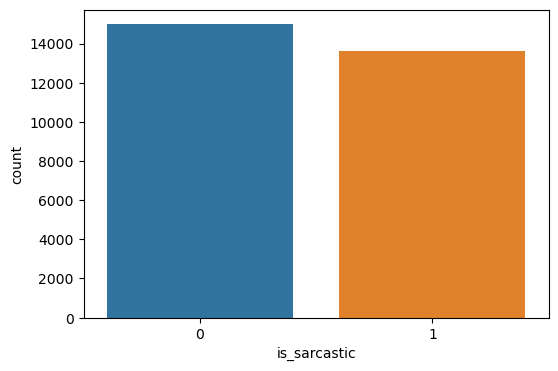

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=[6, 4])
sns.countplot(x = df["is_sarcastic"], data=df)

In [9]:
sentences = df["headline"]
sentences[0]

'thirtysomething scientists unveil doomsday clock of hair loss'

In [10]:
word_count = df["headline"].apply(lambda x: len(x.split()))
min(word_count), max(word_count)

(2, 151)

<Axes: xlabel='headline', ylabel='count'>

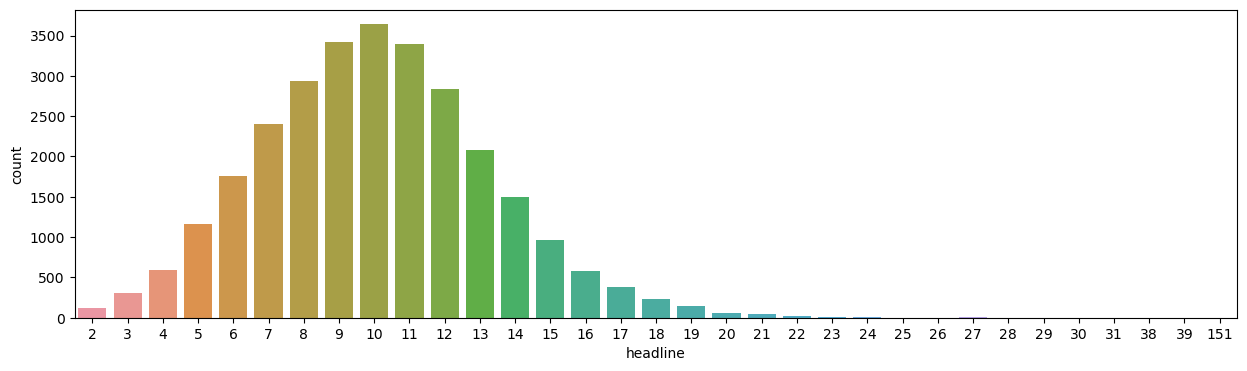

In [11]:
plt.figure(figsize=[15, 4])
sns.countplot(x = word_count)

In [12]:
df["headline"]

0        thirtysomething scientists unveil doomsday clo...
1        dem rep. totally nails why congress is falling...
2        eat your veggies: 9 deliciously different recipes
3        inclement weather prevents liar from getting t...
4        mother comes pretty close to using word 'strea...
                               ...                        
28614         jews to celebrate rosh hashasha or something
28615    internal affairs investigator disappointed con...
28616    the most beautiful acceptance speech this week...
28617    mars probe destroyed by orbiting spielberg-gat...
28618                   dad clarifies this not a food stop
Name: headline, Length: 28619, dtype: object

In [13]:
print(np.max([len(i) for i in df["headline"]]))

926


In [14]:
unique_vocab = set(i for i in df["headline"] for i in i.split())
len(unique_vocab)

38234

In [15]:
sentences = df["headline"]
labels = df["is_sarcastic"]

In [16]:
train_sentences = sentences.iloc[:25000]
test_sentences = sentences.iloc[25000:]

train_labels = labels.iloc[:25000]
test_labels = labels.iloc[25000:]

print(train_sentences.shape, test_sentences.shape)
print(train_labels.shape, test_labels.shape)

(25000,) (3619,)
(25000,) (3619,)


In [17]:
vocabs = 40000
max_length = 926

In [18]:
import tensorflow
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words= vocabs, oov_token = "<oov>")
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_pad = pad_sequences(train_sequences, maxlen = max_length)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_pad = pad_sequences(test_sequences, maxlen = max_length)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [19]:
from keras.layers import Dense, Embedding, Dropout, GlobalAveragePooling1D, BatchNormalization, LSTM, Flatten
from keras import Sequential
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.activations import relu, sigmoid


model = Sequential([
    Embedding(input_dim = vocabs, output_dim= 100, input_length= max_length),
    LSTM(128),
    Dropout(0.5),
    Flatten(),
    Dense(units = 128, activation = relu),
    Dense(units = 1, activation = sigmoid),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 926, 100)          4000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,133,889
Trainable params: 4,133,889
Non-

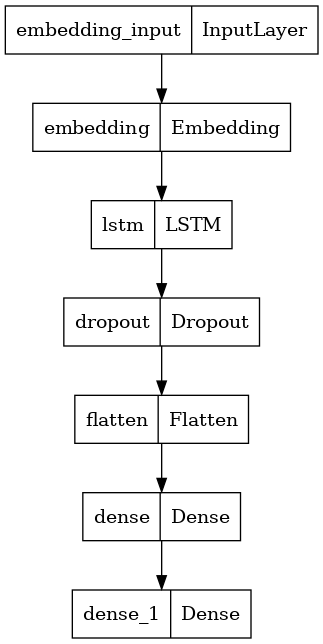

In [20]:
from keras.utils import plot_model
plot_model(model)

In [21]:
model.compile(
    optimizer = Adam(),
    loss = BinaryCrossentropy(),
    metrics=["accuracy"],
)

In [22]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

hist = model.fit(
    train_pad, train_labels,
    epochs = 20,
    validation_data=(test_pad, test_labels),
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
782/782 [==============================] - 71s 84ms/step - loss: 0.3976 - accuracy: 0.8139 - val_loss: 0.3159 - val_accuracy: 0.8627
Epoch 2/20
782/782 [==============================] - 65s 84ms/step - loss: 0.1515 - accuracy: 0.9432 - val_loss: 0.3488 - val_accuracy: 0.8558
Epoch 3/20
782/782 [==============================] - 67s 86ms/step - loss: 0.0527 - accuracy: 0.9814 - val_loss: 0.5614 - val_accuracy: 0.8491
Epoch 4/20
782/782 [==============================] - 65s 83ms/step - loss: 0.0225 - accuracy: 0.9927 - val_loss: 0.6761 - val_accuracy: 0.8431
Epoch 4: early stopping


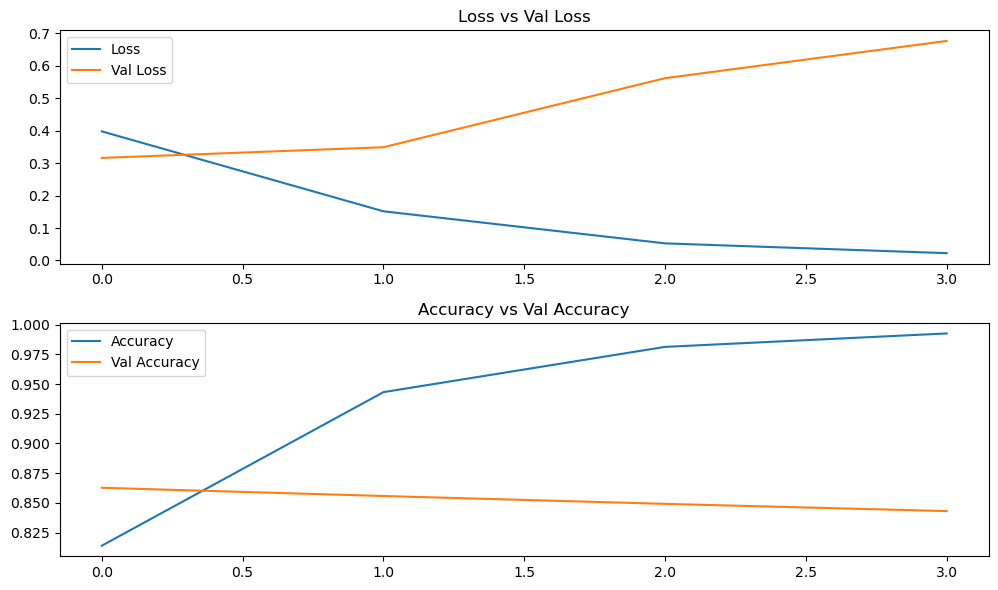

In [23]:
plt.figure(figsize=[10, 6])

plt.subplot(2,1,1)
plt.plot(hist.history["loss"], label="Loss",)
plt.plot(hist.history["val_loss"], label="Val Loss")
plt.title("Loss vs Val Loss")
plt.legend()

plt.subplot(2,1,2)
plt.plot(hist.history["accuracy"], label="Accuracy")
plt.plot(hist.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy vs Val Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
